In [ ]:
from geopy.geocoders import Nominatim
import folium 
from folium.plugins import MarkerCluster 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
sns.set_theme(style="darkgrid")


In [ ]:
geolocator = Nominatim(user_agent= 'example app', timeout=3)

In [ ]:
# We load the csv that we obtained from the webscrapper 
data = pd.read_csv('/content/Inmuebles24_Aguascalientes.csv')

In [ ]:
# We drop the columns that are not useful for us 
df= data.drop("Unnamed: 0", axis=1)
df = df.drop("Unnamed: 0.1", axis=1)

In [60]:
# The webscrapper is designed to fill the mising data with N/A on directions and 0 where no data is given
df.isnull().sum()

Price                    0
Mantainance_cost         0
Total_area [m^2]         0
Constructed_area[m^2]    0
No_rooms                 0
No_bathrooms             0
No_parkings              0
Location                 0
dtype: int64

In [ ]:
# Even when we don't have missing values we mostlikely have duplicated values 
df = df.drop_duplicates()

In [ ]:
# We can see we've passed from 2328 observations to only 1427 when deleting the duplicated values 
df.shape

(1427, 8)

In [ ]:
# We can describe the data after we've deleted the duplicates 
df.describe()

,Price,Mantainance_cost,Total_area [m^2],Constructed_area[m^2],No_rooms,No_bathrooms,No_parkings
count,1.427000e+03,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000
mean,2.393996e+07,184.234057,2841.023826,218.784163,2.301331,1.743518,2.010512
std,1.884857e+08,986.516111,25533.877987,2133.697676,1.669466,1.589792,9.351513
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.250000e+06,0.000000,106.000000,0.000000,0.000000,0.000000,0.000000
50%,2.597328e+06,0.000000,160.000000,127.000000,3.000000,2.000000,2.000000
75%,4.500000e+06,0.000000,252.000000,216.000000,3.000000,3.000000,2.000000
max,2.350000e+09,10000.000000,800000.000000,80000.000000,15.000000,15.000000,200.000000


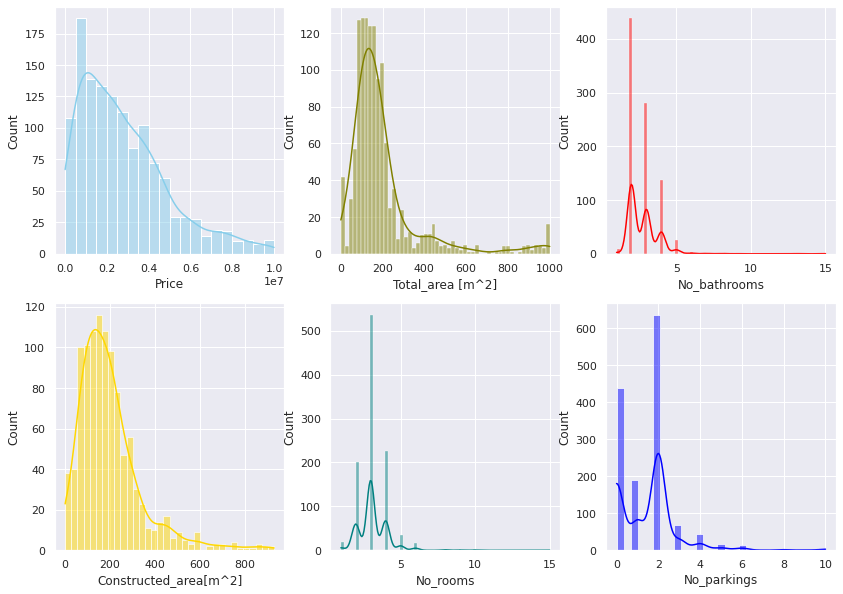

In [65]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))

sns.histplot(data=df[(df['Price'] <= 10000000)], x='Price', kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df[(df['Total_area [m^2]'] <= 1000)],  x='Total_area [m^2]', kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df[(df['No_bathrooms'] <= 15) & (df['No_bathrooms'] > 0)],  x='No_bathrooms', kde=True, color="red", ax=axs[0, 2])
sns.histplot(data=df[(df['Constructed_area[m^2]'] <= 1000) & (df['Constructed_area[m^2]'] > 0)],  x='Constructed_area[m^2]', kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df[(df['No_rooms'] > 0)],  x='No_rooms', kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=df[(df['No_parkings'] <= 10)],  x='No_parkings', kde=True, color="blue", ax=axs[1, 2])



In [ ]:
# Now it's time to filter the data to delete the fake or ilogical posts,  
df1 = df[( df['Price'] <= 4000000) & (df['Total_area [m^2]'] <=1000) & (df['Constructed_area[m^2]']>10) & (df['No_parkings']<100)]

In [ ]:
an = df1.drop('Location', axis =1)

In [ ]:
an = an[an['Total_area [m^2]']>20]

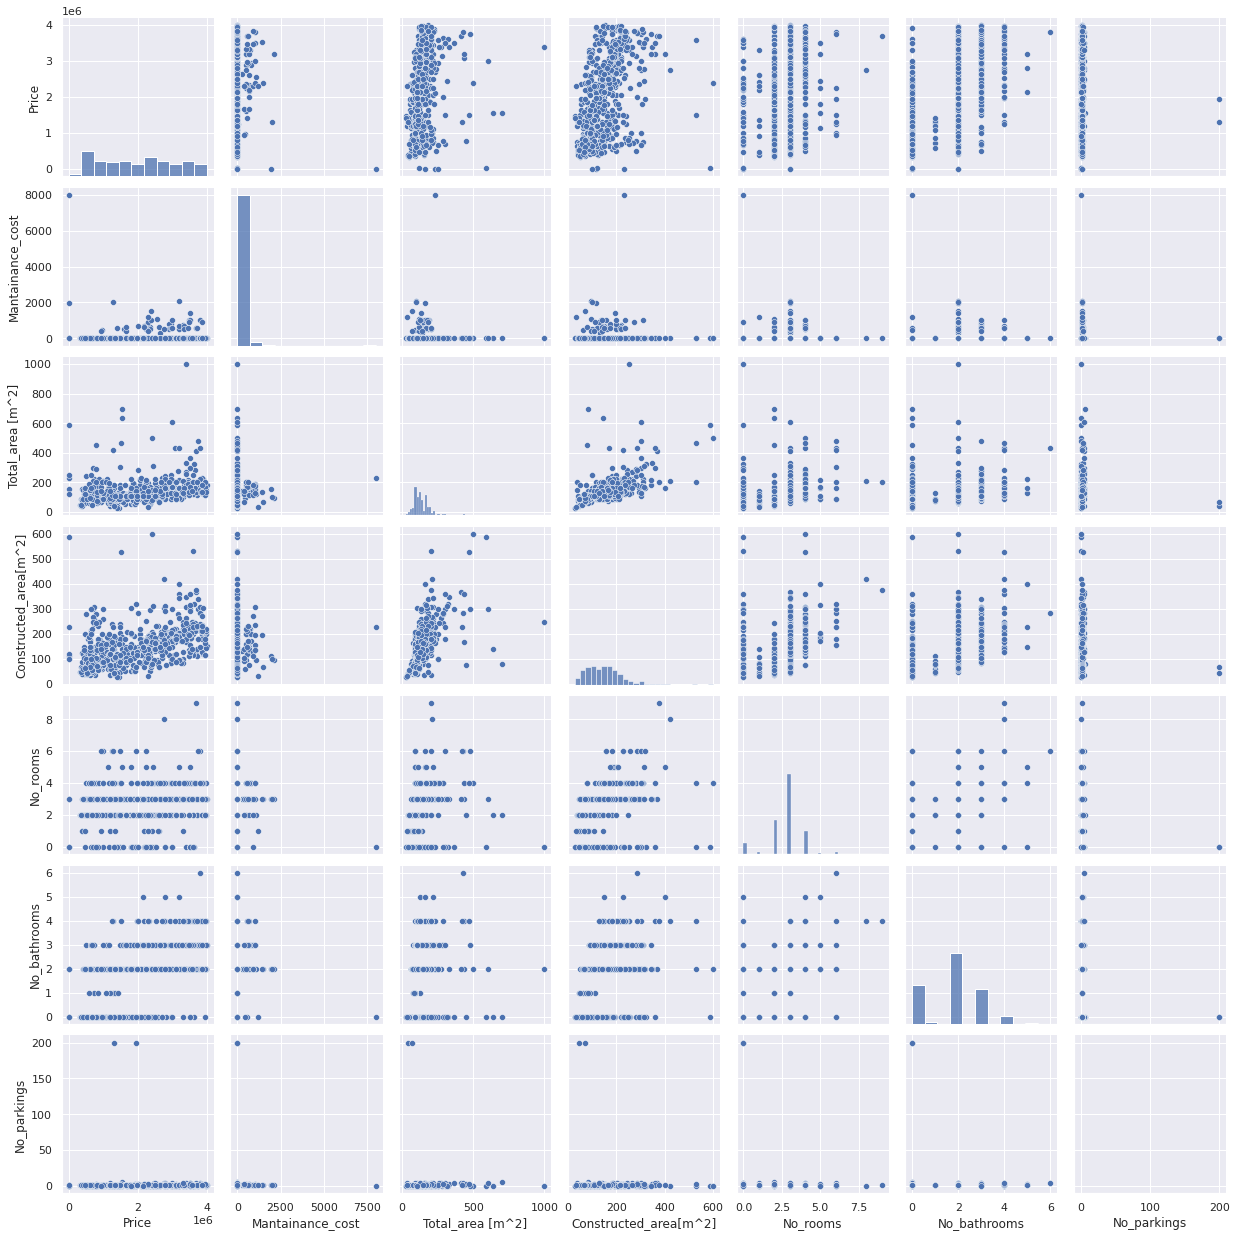

In [ ]:
sns.pairplot(an)

In [ ]:
df = df1[df['Total_area [m^2]']>20]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [ ]:
df["loc"] = df["Location"].apply(geolocator.geocode)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df["point"] = df["loc"].apply(lambda loc: tuple(loc.point) if loc else None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df[['lat', 'lon', 'altitude']] = pd.DataFrame(df['point'].to_list(), index = df.index)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
df.to_csv("Inmuebles24_Aguascalientes_loc.csv")

In [ ]:
m = folium.Map(location = df[['lat', 'lon']].mean().to_list(), zoom_star = 2)

marker_cluster = MarkerCluster().add_to(m)

In [ ]:
df = df.dropna()

In [ ]:
for i, r in df.iterrows() : 
  location = (r["lat"], r["lon"])
  folium.Marker(location = location, popup = r['Price']).add_to(marker_cluster)

In [ ]:
m

In [ ]:
df['price_m^2'] =  df['Price']/df['Total_area [m^2]']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.describe()

,Price,Mantainance_cost,Total_area [m^2],Constructed_area[m^2],No_rooms,No_bathrooms,No_parkings,lat,lon,altitude,price_m^2
count,4.860000e+02,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.0,4.840000e+02
mean,6.352579e+06,116.430041,3863.281893,162.722222,2.380658,1.835391,1.590535,22.611364,-95.078896,0.0,inf
std,2.252683e+07,781.355855,38919.941637,237.467591,1.823432,1.714000,2.899526,5.515497,29.922827,0.0,NaN
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.452327,-102.729301,0.0,0.000000e+00
25%,1.352831e+06,0.000000,112.000000,0.000000,0.000000,0.000000,0.000000,21.880487,-102.297136,0.0,7.194048e+03
50%,2.699000e+06,0.000000,160.000000,130.000000,3.000000,2.000000,2.000000,21.880487,-102.296719,0.0,1.621911e+04
75%,4.350788e+06,0.000000,250.000000,214.000000,3.000000,3.000000,2.000000,21.940437,-102.192251,0.0,2.431301e+04
max,3.110000e+08,9000.000000,800000.000000,2859.000000,15.000000,15.000000,50.000000,53.229575,135.828520,0.0,inf
